In [1]:
import gym
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import base64, io
import math
import pandas as pd

import numpy as np
from collections import deque, namedtuple
import glob

from contextlib import closing
from io import StringIO
from os import path
from typing import List, Optional

import numpy as np

from gym import Env, spaces, utils
import torch.multiprocessing
from gym.error import DependencyNotInstalled
from gym.envs.toy_text.utils import categorical_sample
import highway_env

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

C:\Anaconda3\lib\site-packages\ipykernel\pylab\backend_inline.py:164: DeprecationWarning: `configure_inline_support` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.configure_inline_support()`
  configure_inline_support(ip, backend)
C:\Anaconda3\lib\site-packages\gym\core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [2]:
class FlattenObsWrapper(gym.ObservationWrapper):
    def __init__(self, env, dtype=np.float32):
        super(FlattenObsWrapper, self).__init__(env)
        self.dtype = dtype
        old_space = env.observation_space
        self.state_len = old_space.shape[0] * old_space.shape[1]
        self.observation_space = gym.spaces.Box(old_space.low[0][0].repeat(self.state_len,
                 axis=0),old_space.high[0][0].repeat(self.state_len, axis=0),
                 dtype=dtype)
    def reset(self, seed=0):
        self.buffer = np.zeros_like(self.observation_space.low,
        dtype=self.dtype)
        return self.observation(self.env.reset())
    def observation(self, observation):
        self.buffer = np.array([elem for elem in observation])
        return self.buffer

C:\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Environment from https://github.com/eleurent/highway-env

In [3]:
class QNetwork(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
        """
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_size)

    def forward(self, state):
        """Build a network that maps state -> action values."""
        x = self.fc1(state)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        return self.fc3(x)


In [4]:
class OneHotDQN(nn.Module):
    def __init__(self, num_inputs, num_actions):
        super(OneHotDQN, self).__init__()

        num_feats = num_inputs
        self.dummy_param = nn.Parameter(torch.empty(0))  # to get the device name designated to the module

        self.q_layer = nn.Sequential(
            nn.Linear(num_feats, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, num_actions),
        )

    def forward(self, state):
        # to get the device assigned to the module at initalization
        device = self.dummy_param.device
        if type(state) != torch.Tensor:
            state = torch.Tensor(state).to(device=device)

        q_vals = self.q_layer(state)
        return q_vals
    

class OneHotValueNetwork(nn.Module):
    def __init__(self, num_inputs):
        super(OneHotValueNetwork, self).__init__()

        num_feats = num_inputs
        self.dummy_param = nn.Parameter(torch.empty(0))  # to get the device name designated to the module
        self.value = nn.Sequential(
            nn.Linear(num_feats, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
        )

    def forward(self, state):
        # to get the device assigned to the module at initalization
        device = self.dummy_param.device
        if type(state) != torch.Tensor:
            state = torch.Tensor(state).to(device=device)

        val = self.value(state)
        return val

==========================================================================================================================

In [5]:

class Agent():
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size, alpha=0.05, gamma=0.99, seed=0, update_every=4, batch_size=128):
        """Initialize an Agent object.

        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)
        self.gamma= gamma
        self.update_interval = update_every
        self.batch_size = batch_size

        # Q-Network
        self.qnetwork_local = QNetwork(self.state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork(self.state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=alpha)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        self.transition_matrix = np.zeros((self.state_size, action_size, self.state_size))
        self.transition_matrix = np.zeros((self.state_size, action_size, self.state_size))
        # Occupancy measure
        self.occupancy = OccupancyVector()
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0

    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)
        self.occupancy.add(state, next_state)
        #update state transition matrix
        self.transition_matrix[np.argmax(state)][action][np.argmax(next_state)] = 1
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % self.update_interval
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > self.batch_size:
                experiences = self.memory.sample()
                self.learn(experiences, self.gamma)

    def get_regret(self, state, prev_state, action):
        self.qnetwork_local.eval()
        #get regret for current action given potential true states
        #potential true states given previous state
        true_states = np.argmax(self.transition_matrix[np.argmax(prev_state)], axis=1)
        true_states = np.array([statehelper(s) for s in true_states])
        actions = np.full((self.action_size,1), action)
        #print(state, true_states)
        assert state in true_states

        #expected value of current s,a
        s = torch.tensor(state).float().unsqueeze(0).to(device)
        a = torch.tensor([action]).long().unsqueeze(0).to(device)
        v = self.qnetwork_local(s).gather(1, a).cpu().detach().numpy()
        v = max(v,0)

        #expected value of potential observations
        ts = torch.tensor(true_states).float().unsqueeze(0).to(device)[0]
        ta = torch.tensor(actions).long().unsqueeze(0).to(device)[0]
        v_alt = self.qnetwork_local(ts).gather(1, ta).cpu().detach().numpy()
        v_alt = np.where(v_alt<0,0,v_alt)

        #assert v in v_alt
        self.qnetwork_local.train()

        #regret calculation V(s,a) - min_V(true_s,a)
        regret = np.max(v_alt) - v
        if not isinstance(regret, np.ndarray):
            return regret
        return regret[0][0]

    def get_regret_lower(self, state, prev_state, action):
        #regret for lower policy, but meta agent contains actual values
        self.qnetwork_local.eval()
        #get regret for current action given potential true states
        #potential true states given previous state
        true_states = np.array([perturb_state(np.argmax(prev_state), a) for a in range(env.action_space.n)])
        true_states = np.array([statehelper(s) for s in true_states])
        actions = np.array([[perturb_state(np.argmax(s), action)] for s in true_states])
        assert state in true_states

        #expected value of current s,a
        s = torch.tensor(state).float().unsqueeze(0).to(device)
        a = torch.tensor([perturb_state(np.argmax(state), action)]).long().unsqueeze(0).to(device)
        v = self.qnetwork_local(s).gather(1, a).cpu().detach().numpy()
        v = max(v,0)

        #expected value of potential observations
        ts = torch.tensor(true_states).float().unsqueeze(0).to(device)[0]
        ta = torch.tensor(actions).long().unsqueeze(0).to(device)[0]
        v_alt = self.qnetwork_local(ts).gather(1, ta).cpu().detach().numpy()
        v_alt = np.where(v_alt<0,0,v_alt)

        assert s in ts
        #assert a in ta
        self.qnetwork_local.train()

        #regret calculation V(s,a) - min_V(true_s,a)
        regret = np.max(v_alt) - v
        if not isinstance(regret, np.ndarray):
            return regret
        return regret[0][0]

    def act(self, state, eps=0.):
        """Returns actions for given state as per current policy.

        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        if(torch.is_tensor(state)):
            state = state.float().unsqueeze(0).to(device)
        else:
            state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()
        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.

        Params
        ======
            experiences (Tuple[torch.Variable]): tuple of (s, a, r, s', done) tuples
            gamma (float): discount factor
        """
        # Obtain random minibatch of tuples from D
        states, actions, rewards, next_states, dones = experiences
        ## Compute and minimize the loss
        ### Extract next maximum estimated value from target network
        q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)

        ### Calculate target value from bellman equation
        q_targets = rewards + gamma * q_targets_next * (1 - dones)
        ### Calculate expected value from local network
        q_expected = self.qnetwork_local(states).gather(1, actions)
        ### Loss calculation (we used Mean squared error)
        loss = F.mse_loss(q_expected, q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)


In [6]:
class BVF_Agent():
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size, alpha=0.05, gamma=0.99, seed=0, update_every=4, batch_size=128):
        """Initialize an Agent object.

        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.constraint = constraint
        self.seed = random.seed(seed)
        self.gamma= gamma
        self.update_interval = update_every
        self.batch_size = batch_size

        # Q-Network
        self.qnetwork_local = QNetwork(self.state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork(self.state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=alpha)
        
        # Q-Cost-Network
        self.qnetwork_forward = OneHotDQN(self.state_size, action_size).to(device)
        self.optimizer1 = optim.Adam(self.qnetwork_forward.parameters(), lr=alpha)
        self.qnetwork_backward = OneHotValueNetwork(self.state_size).to(device)
        self.optimizer2 = optim.Adam(self.qnetwork_backward.parameters(), lr=alpha)

        # Replay memory
        self.memory = Safe_ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        self.transition_matrix = np.zeros((self.state_size, action_size, self.state_size))
        self.transition_matrix = np.zeros((self.state_size, action_size, self.state_size))
        # Occupancy measure
        self.occupancy = OccupancyVector()
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0

    def step(self, state, constraint, action, reward, next_state, next_constraint, done):
        # Save experience in replay memory
        self.memory.add(state,constraint, action, reward, next_state, next_constraint, done)
        self.occupancy.add(state, next_state)
        #update state transition matrix
        self.transition_matrix[np.argmax(state)][action][np.argmax(next_state)] = 1
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % self.update_interval
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > self.batch_size:
                experiences = self.memory.sample()
                self.learn(experiences, self.gamma)

    def get_regret(self, state, prev_state, action):
        self.qnetwork_local.eval()
        #get regret for current action given potential true states
        #potential true states given previous state
        true_states = np.argmax(self.transition_matrix[np.argmax(prev_state)], axis=1)
        true_states = np.array([statehelper(s) for s in true_states])
        actions = np.full((self.action_size,1), action)
        #print(state, true_states)
        assert state in true_states

        #expected value of current s,a
        s = torch.tensor(state).float().unsqueeze(0).to(device)
        a = torch.tensor([action]).long().unsqueeze(0).to(device)
        v = self.qnetwork_local(s).gather(1, a).cpu().detach().numpy()
        v = max(v,0)

        #expected value of potential observations
        ts = torch.tensor(true_states).float().unsqueeze(0).to(device)[0]
        ta = torch.tensor(actions).long().unsqueeze(0).to(device)[0]
        v_alt = self.qnetwork_local(ts).gather(1, ta).cpu().detach().numpy()
        v_alt = np.where(v_alt<0,0,v_alt)

        #assert v in v_alt
        self.qnetwork_local.train()

        #regret calculation V(s,a) - min_V(true_s,a)
        regret = np.max(v_alt) - v
        if not isinstance(regret, np.ndarray):
            return regret
        return regret[0][0]

    def get_regret_lower(self, state, prev_state, action):
        #regret for lower policy, but meta agent contains actual values
        self.qnetwork_local.eval()
        #get regret for current action given potential true states
        #potential true states given previous state
        true_states = np.array([perturb_state(np.argmax(prev_state), a) for a in range(env.action_space.n)])
        true_states = np.array([statehelper(s) for s in true_states])
        actions = np.array([[perturb_state(np.argmax(s), action)] for s in true_states])
        assert state in true_states

        #expected value of current s,a
        s = torch.tensor(state).float().unsqueeze(0).to(device)
        a = torch.tensor([perturb_state(np.argmax(state), action)]).long().unsqueeze(0).to(device)
        v = self.qnetwork_local(s).gather(1, a).cpu().detach().numpy()
        v = max(v,0)

        #expected value of potential observations
        ts = torch.tensor(true_states).float().unsqueeze(0).to(device)[0]
        ta = torch.tensor(actions).long().unsqueeze(0).to(device)[0]
        v_alt = self.qnetwork_local(ts).gather(1, ta).cpu().detach().numpy()
        v_alt = np.where(v_alt<0,0,v_alt)

        assert s in ts
        #assert a in ta
        self.qnetwork_local.train()

        #regret calculation V(s,a) - min_V(true_s,a)
        regret = np.max(v_alt) - v
        if not isinstance(regret, np.ndarray):
            return regret
        return regret[0][0]

    def act(self, state, cons,eps=0.):
        """Returns actions for given state as per current policy.

        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        if(torch.is_tensor(state)):
            state = state.float().unsqueeze(0).to(device)
        else:
            state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()
            
        c_f = self.qnetwork_forward(state)
        c_b = self.qnetwork_backward(state)
        #quantity_1 = c_f + c_b
        quantity_1 = c_b
        quantity_2 = self.constraint + cons
        
        constraint_mask = torch.le(quantity_1, quantity_2).float().squeeze(0)
        filtered_Q = (action_values + 1000.0) * (constraint_mask)
        filtered_action = np.argmax(filtered_Q.cpu().data.numpy())
        
        alt_Q = -1. * c_f
        alt_action =np.argmax(alt_Q.cpu().data.numpy())
        c_sum = constraint_mask.sum(0)
        action_mask = (c_sum == torch.zeros_like(c_sum)).cpu().numpy()
        action = (1 - action_mask) * filtered_action + action_mask * alt_action
        
        
        
        # Epsilon-greedy action selection
        if random.random() > eps:
            #return np.argmax(action_values.cpu().data.numpy())
            return action, c_f[0][action].item(), c_b[0].item()
        else:
            action_r = random.choice(np.arange(self.action_size))
            return action_r, c_f[0][action_r].item(), c_b[0].item()

    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.

        Params
        ======
            experiences (Tuple[torch.Variable]): tuple of (s, a, r, s', done) tuples
            gamma (float): discount factor
        """
        # Obtain random minibatch of tuples from D
        states, constraints, actions, rewards, next_states, next_constraints, dones = experiences
       
        ## Compute and minimize the loss
        ### Extract next maximum estimated value from target network
        q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)

        ### Calculate target value from bellman equation
        q_targets = rewards + gamma * q_targets_next * (1 - dones)
        ### Calculate expected value from local network
        q_expected = self.qnetwork_local(states).gather(1, actions)
        ### Loss calculation (we used Mean squared error)
        loss = F.mse_loss(q_expected, q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        
        ### Calculate target cost from bellman equation
        #c_targets1 = constraints
        c_targets1 = self.qnetwork_forward(next_states).detach().min(1)[0].unsqueeze(1)
        #c_targets1 = c_targets1.gather(1, actions)
        ### Calculate expected cost from qnetwork_forward
        c_expected1 = self.qnetwork_forward(states).gather(1, actions)
        ### Loss calculation (we used Mean squared error)
        loss1 = F.mse_loss(c_expected1, c_targets1)
        self.optimizer1.zero_grad()
        loss1.backward()
        self.optimizer1.step()
        

        ### Calculate target cost from bellman equation
        #c_targets2 = constraints
        c_targets2 = self.qnetwork_backward(next_states).detach().min(1)[0].unsqueeze(1)
        #c_targets2 = c_targets2.gather(1, actions)
        ### Calculate expected cost from qnetwork_backward
        c_expected2 = self.qnetwork_backward(states)
        ### Loss calculation (we used Mean squared error)
        loss2 = F.mse_loss(c_expected2, c_targets2)
        self.optimizer2.zero_grad()
        loss2.backward()
        self.optimizer2.step()

        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

In [7]:
class Safe_Agent():
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size, constraint, alpha=0.05, gamma=0.99, seed=0, update_every=4, batch_size=128):
        """Initialize an Agent object.

        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            constraint (int): Number of constraint
            seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.constraint = constraint
        self.seed = random.seed(seed)
        self.gamma= gamma
        self.update_interval = update_every
        self.batch_size = batch_size
        
        
        # Q-Network
        self.qnetwork_local = QNetwork(self.state_size+1, action_size, seed).to(device)
        self.qnetwork_target = QNetwork(self.state_size+1, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=alpha)

        # Replay memory
        self.memory = Safe_ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        self.transition_matrix = np.zeros((self.state_size, action_size, self.state_size))
        self.transition_matrix = np.zeros((self.state_size, action_size, self.state_size))
        # Occupancy measure
        self.occupancy = OccupancyVector()
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0

    def step(self, state, constraint, action, reward, next_state, next_constraint, done):
        # Save experience in replay memory
        self.memory.add(state,constraint, action, reward, next_state, next_constraint, done)
        self.occupancy.add(state, next_state)
        #update state transition matrix
        self.transition_matrix[np.argmax(state)][action][np.argmax(next_state)] = 1
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % self.update_interval
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > self.batch_size:
                experiences = self.memory.sample()
                self.learn(experiences, self.gamma)

    def get_regret(self, state, prev_state, action):
        self.qnetwork_local.eval()
        #get regret for current action given potential true states
        #potential true states given previous state
        true_states = np.argmax(self.transition_matrix[np.argmax(prev_state)], axis=1)
        true_states = np.array([statehelper(s) for s in true_states])
        actions = np.full((self.action_size,1), action)
        #print(state, true_states)
        assert state in true_states

        #expected value of current s,a
        s = torch.tensor(state).float().unsqueeze(0).to(device)
        a = torch.tensor([action]).long().unsqueeze(0).to(device)
        v = self.qnetwork_local(s).gather(1, a).cpu().detach().numpy()
        v = max(v,0)

        #expected value of potential observations
        ts = torch.tensor(true_states).float().unsqueeze(0).to(device)[0]
        ta = torch.tensor(actions).long().unsqueeze(0).to(device)[0]
        v_alt = self.qnetwork_local(ts).gather(1, ta).cpu().detach().numpy()
        v_alt = np.where(v_alt<0,0,v_alt)

        #assert v in v_alt
        self.qnetwork_local.train()

        #regret calculation V(s,a) - min_V(true_s,a)
        regret = np.max(v_alt) - v
        if not isinstance(regret, np.ndarray):
            return regret
        return regret[0][0]

    def get_regret_lower(self, state, prev_state, action):
        #regret for lower policy, but meta agent contains actual values
        self.qnetwork_local.eval()
        #get regret for current action given potential true states
        #potential true states given previous state
        true_states = np.array([perturb_state(np.argmax(prev_state), a) for a in range(env.action_space.n)])
        true_states = np.array([statehelper(s) for s in true_states])
        actions = np.array([[perturb_state(np.argmax(s), action)] for s in true_states])
        assert state in true_states

        #expected value of current s,a
        s = torch.tensor(state).float().unsqueeze(0).to(device)
        a = torch.tensor([perturb_state(np.argmax(state), action)]).long().unsqueeze(0).to(device)
        v = self.qnetwork_local(s).gather(1, a).cpu().detach().numpy()
        v = max(v,0)

        #expected value of potential observations
        ts = torch.tensor(true_states).float().unsqueeze(0).to(device)[0]
        ta = torch.tensor(actions).long().unsqueeze(0).to(device)[0]
        v_alt = self.qnetwork_local(ts).gather(1, ta).cpu().detach().numpy()
        v_alt = np.where(v_alt<0,0,v_alt)

        assert s in ts
        #assert a in ta
        self.qnetwork_local.train()

        #regret calculation V(s,a) - min_V(true_s,a)
        regret = np.max(v_alt) - v
        if not isinstance(regret, np.ndarray):
            return regret
        return regret[0][0]

    def act(self, state_constraint, eps=0.):
        """Returns actions for given state as per current policy.

        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        if(torch.is_tensor(state_constraint)):
            state_constraint = state_constraint.float().unsqueeze(0).to(device)
        else:
            state_constraint = torch.from_numpy(state_constraint).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state_constraint)
        self.qnetwork_local.train()
        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.

        Params
        ======
            experiences (Tuple[torch.Variable]): tuple of (s, a, r, s', done) tuples
            gamma (float): discount factor
        """
        # Obtain random minibatch of tuples from D
        states, constraints, actions, rewards, next_states, next_constraints, dones = experiences
        next_states_next_constraints=torch.cat((next_states,next_constraints),dim=1)
        states_constraints=torch.cat((states,constraints),dim=1)
        ## Compute and minimize the loss
        ### Extract next maximum estimated value from target network
        q_targets_next = self.qnetwork_target(next_states_next_constraints).detach().max(1)[0].unsqueeze(1)

        ### Calculate target value from bellman equation
        constraint_mask = torch.le(constraints, self.constraint).float().squeeze(0)
        r = rewards
        for i in range(len(constraint_mask)):
            if constraint_mask[i] == 0:
                r[i] -= 1
        q_targets = r + gamma * q_targets_next * (1 - dones)
        ### Calculate expected value from local network
        q_expected = self.qnetwork_local(states_constraints).gather(1, actions)
        ### Loss calculation (we used Mean squared error)
        loss = F.mse_loss(q_expected, q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)


In [8]:
class LYP_Agent():
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size, constraint, alpha=0.05, gamma=0.99, seed=0, update_every=4, batch_size=128):
        """Initialize an Agent object.

        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)
        self.gamma= gamma
        self.update_interval = update_every
        self.batch_size = batch_size
        self.constraint = constraint

        # Q-Network
        self.qnetwork_local = QNetwork(self.state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork(self.state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=alpha)
        
        # Q-Cost-Network
        self.qnetwork_forward = OneHotDQN(self.state_size, action_size).to(device)
        self.qnetwork_forward_target = OneHotDQN(self.state_size, action_size).to(device)
        self.optimizer_c = optim.Adam(self.qnetwork_forward.parameters(), lr=alpha)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        self.transition_matrix = np.zeros((self.state_size, action_size, self.state_size))
        self.transition_matrix = np.zeros((self.state_size, action_size, self.state_size))
        # Occupancy measure
        self.occupancy = OccupancyVector()
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0

    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)
        self.occupancy.add(state, next_state)
        #update state transition matrix
        self.transition_matrix[np.argmax(state)][action][np.argmax(next_state)] = 1
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % self.update_interval
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > self.batch_size:
                experiences = self.memory.sample()
                self.learn(experiences, self.gamma)

    def get_regret(self, state, prev_state, action):
        self.qnetwork_local.eval()
        #get regret for current action given potential true states
        #potential true states given previous state
        true_states = np.argmax(self.transition_matrix[np.argmax(prev_state)], axis=1)
        true_states = np.array([statehelper(s) for s in true_states])
        actions = np.full((self.action_size,1), action)
        #print(state, true_states)
        assert state in true_states

        #expected value of current s,a
        s = torch.tensor(state).float().unsqueeze(0).to(device)
        a = torch.tensor([action]).long().unsqueeze(0).to(device)
        v = self.qnetwork_local(s).gather(1, a).cpu().detach().numpy()
        v = max(v,0)

        #expected value of potential observations
        ts = torch.tensor(true_states).float().unsqueeze(0).to(device)[0]
        ta = torch.tensor(actions).long().unsqueeze(0).to(device)[0]
        v_alt = self.qnetwork_local(ts).gather(1, ta).cpu().detach().numpy()
        v_alt = np.where(v_alt<0,0,v_alt)

        #assert v in v_alt
        self.qnetwork_local.train()

        #regret calculation V(s,a) - min_V(true_s,a)
        regret = np.max(v_alt) - v
        if not isinstance(regret, np.ndarray):
            return regret
        return regret[0][0]

    def get_regret_lower(self, state, prev_state, action):
        #regret for lower policy, but meta agent contains actual values
        self.qnetwork_local.eval()
        #get regret for current action given potential true states
        #potential true states given previous state
        true_states = np.array([perturb_state(np.argmax(prev_state), a) for a in range(env.action_space.n)])
        true_states = np.array([statehelper(s) for s in true_states])
        actions = np.array([[perturb_state(np.argmax(s), action)] for s in true_states])
        assert state in true_states

        #expected value of current s,a
        s = torch.tensor(state).float().unsqueeze(0).to(device)
        a = torch.tensor([perturb_state(np.argmax(state), action)]).long().unsqueeze(0).to(device)
        v = self.qnetwork_local(s).gather(1, a).cpu().detach().numpy()
        v = max(v,0)

        #expected value of potential observations
        ts = torch.tensor(true_states).float().unsqueeze(0).to(device)[0]
        ta = torch.tensor(actions).long().unsqueeze(0).to(device)[0]
        v_alt = self.qnetwork_local(ts).gather(1, ta).cpu().detach().numpy()
        v_alt = np.where(v_alt<0,0,v_alt)

        assert s in ts
        #assert a in ta
        self.qnetwork_local.train()

        #regret calculation V(s,a) - min_V(true_s,a)
        regret = np.max(v_alt) - v
        if not isinstance(regret, np.ndarray):
            return regret
        return regret[0][0]
    
    def act(self, state, cons, eps=0.):
        """Returns actions for given state as per current policy.

        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        if(torch.is_tensor(state)):
            state = state.float().unsqueeze(0).to(device)
        else:
            state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            q_value = self.qnetwork_local(state)
        self.qnetwork_local.train()

        self.qnetwork_forward.eval()
        with torch.no_grad():
            cost_q_val = self.qnetwork_forward(state)
        self.qnetwork_forward.train()
        
        max_q_val = cost_q_val.max(1)[0].unsqueeze(1)
        
        epsilon = (1 - self.gamma) * (self.constraint - cons)
        
        constraint_mask = torch.le(cost_q_val , epsilon + max_q_val).float()

        filtered_Q = (q_value + 1000.0) * (constraint_mask)

        filtered_action = filtered_Q.max(1)[1].cpu().numpy()
        
        alt_action = (-1. * cost_q_val).max(1)[1].cpu().numpy()
        
        c_sum = constraint_mask.sum(1)
        action_mask = (c_sum == torch.zeros_like(c_sum)).cpu().numpy()
        
        action = (1 - action_mask) * filtered_action + action_mask * alt_action
        

        # Epsilon-greedy action selection
        if random.random() > eps:
            #return np.argmax(action_values.cpu().data.numpy())
            return action[0]
        else:
            action_r = random.choice(np.arange(self.action_size))
            return action_r

    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.

        Params
        ======
            experiences (Tuple[torch.Variable]): tuple of (s, a, r, s', done) tuples
            gamma (float): discount factor
        """
        # Obtain random minibatch of tuples from D
        states, actions, rewards, next_states, dones = experiences
        ## Compute and minimize the loss
        ### Extract next maximum estimated value from target network
        q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)

        ### Calculate target value from bellman equation
        q_targets = rewards + gamma * q_targets_next * (1 - dones)
        ### Calculate expected value from local network
        q_expected = self.qnetwork_local(states).gather(1, actions)
        ### Loss calculation (we used Mean squared error)
        loss = F.mse_loss(q_expected, q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        ### Calculate target cost from bellman equation
        c_targets_c = self.qnetwork_forward_target(next_states).detach().min(1)[0].unsqueeze(1)
        
        ### Calculate expected cost from qnetwork_forward
        c_expected_c = self.qnetwork_forward(states).gather(1, actions)
        ### Loss calculation (we used Mean squared error)
        loss_c = F.mse_loss(c_expected_c, c_targets_c)
        self.optimizer_c.zero_grad()
        loss_c.backward()
        self.optimizer_c.step()


        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)
        self.soft_update(self.qnetwork_forward, self.qnetwork_forward_target, TAU)

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)


In [9]:
class SAC_Agent():
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size, constraint,alpha=0.05, gamma=0.99, seed=0, update_every=4, batch_size=128):
        """Initialize an Agent object.

        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.constraint = constraint
        self.seed = random.seed(seed)
        self.gamma= gamma
        self.update_interval = update_every
        self.batch_size = batch_size

        # Q-Networks
        self.qnetwork_local_1 = QNetwork(self.state_size+1, action_size, seed).to(device)
        self.qnetwork_target_1 = QNetwork(self.state_size+1, action_size, seed).to(device)
        self.optimizer_1 = optim.Adam(self.qnetwork_local_1.parameters(), lr=alpha)
        
        self.qnetwork_local_2 = QNetwork(self.state_size+1, action_size, seed).to(device)
        self.qnetwork_target_2 = QNetwork(self.state_size+1, action_size, seed).to(device)
        self.optimizer_2 = optim.Adam(self.qnetwork_local_2.parameters(), lr=alpha)
        
        # Q-Cost-Network
        self.qnetwork_forward_1 = OneHotDQN(self.state_size+1, action_size).to(device)
        self.qnetwork_forward_target_1 = OneHotDQN(self.state_size+1, action_size).to(device)
        self.optimizer_c_1 = optim.Adam(self.qnetwork_forward_1.parameters(), lr=alpha)
        
        self.qnetwork_forward_2 = OneHotDQN(self.state_size+1, action_size).to(device)
        self.qnetwork_forward_target_2 = OneHotDQN(self.state_size+1, action_size).to(device)
        self.optimizer_c_2 = optim.Adam(self.qnetwork_forward_2.parameters(), lr=alpha)

        # Replay memory
        self.memory = Safe_ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        self.transition_matrix = np.zeros((self.state_size, action_size, self.state_size))
        self.transition_matrix = np.zeros((self.state_size, action_size, self.state_size))
        # Occupancy measure
        self.occupancy = OccupancyVector()
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0

    def step(self, state, constraint, action, reward, next_state, next_constraint, done):
        # Save experience in replay memory
        self.memory.add(state,constraint, action, reward, next_state, next_constraint, done)
        self.occupancy.add(state, next_state)
        #update state transition matrix
        self.transition_matrix[np.argmax(state)][action][np.argmax(next_state)] = 1
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % self.update_interval
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > self.batch_size:
                experiences = self.memory.sample()
                self.learn(experiences, self.gamma)

    def get_regret(self, state, prev_state, action):
        self.qnetwork_local.eval()
        #get regret for current action given potential true states
        #potential true states given previous state
        true_states = np.argmax(self.transition_matrix[np.argmax(prev_state)], axis=1)
        true_states = np.array([statehelper(s) for s in true_states])
        actions = np.full((self.action_size,1), action)
        #print(state, true_states)
        assert state in true_states

        #expected value of current s,a
        s = torch.tensor(state).float().unsqueeze(0).to(device)
        a = torch.tensor([action]).long().unsqueeze(0).to(device)
        v = self.qnetwork_local(s).gather(1, a).cpu().detach().numpy()
        v = max(v,0)

        #expected value of potential observations
        ts = torch.tensor(true_states).float().unsqueeze(0).to(device)[0]
        ta = torch.tensor(actions).long().unsqueeze(0).to(device)[0]
        v_alt = self.qnetwork_local(ts).gather(1, ta).cpu().detach().numpy()
        v_alt = np.where(v_alt<0,0,v_alt)

        #assert v in v_alt
        self.qnetwork_local.train()

        #regret calculation V(s,a) - min_V(true_s,a)
        regret = np.max(v_alt) - v
        if not isinstance(regret, np.ndarray):
            return regret
        return regret[0][0]

    def get_regret_lower(self, state, prev_state, action):
        #regret for lower policy, but meta agent contains actual values
        self.qnetwork_local.eval()
        #get regret for current action given potential true states
        #potential true states given previous state
        true_states = np.array([perturb_state(np.argmax(prev_state), a) for a in range(env.action_space.n)])
        true_states = np.array([statehelper(s) for s in true_states])
        actions = np.array([[perturb_state(np.argmax(s), action)] for s in true_states])
        assert state in true_states

        #expected value of current s,a
        s = torch.tensor(state).float().unsqueeze(0).to(device)
        a = torch.tensor([perturb_state(np.argmax(state), action)]).long().unsqueeze(0).to(device)
        v = self.qnetwork_local(s).gather(1, a).cpu().detach().numpy()
        v = max(v,0)

        #expected value of potential observations
        ts = torch.tensor(true_states).float().unsqueeze(0).to(device)[0]
        ta = torch.tensor(actions).long().unsqueeze(0).to(device)[0]
        v_alt = self.qnetwork_local(ts).gather(1, ta).cpu().detach().numpy()
        v_alt = np.where(v_alt<0,0,v_alt)

        assert s in ts
        #assert a in ta
        self.qnetwork_local.train()

        #regret calculation V(s,a) - min_V(true_s,a)
        regret = np.max(v_alt) - v
        if not isinstance(regret, np.ndarray):
            return regret
        return regret[0][0]

    def act(self, state, constraint, cons, eps=0.):
        """Returns actions for given state as per current policy.

        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        lamb = 1
        state_constraint = torch.cat((state, constraint))
        if(torch.is_tensor(state_constraint)):
            state_constraint = state_constraint.float().unsqueeze(0).to(device)
        else:
            state_constraint = torch.from_numpy(state_constraint).float().unsqueeze(0).to(device)
        self.qnetwork_local_1.eval()
        self.qnetwork_local_2.eval()
        with torch.no_grad():
            action_values = torch.zeros(1,self.action_size).to(device)
            for i in range(self.action_size):
                action_values[0][i] = min(self.qnetwork_local_1(state_constraint)[0][i],self.qnetwork_local_2(state_constraint)[0][i])
        self.qnetwork_local_1.train()
        self.qnetwork_local_2.train()
        #print("Values: ",action_values)
        self.qnetwork_forward_1.eval()
        self.qnetwork_forward_2.eval()
        with torch.no_grad():
            c_f_1 = self.qnetwork_forward_1(state_constraint)
            c_f_2 = self.qnetwork_forward_2(state_constraint)
            c_f = c_f_1
            for i in range(len(c_f)):
                c_f[0][i] = max(c_f_1[0][i],c_f_2[0][i])
        self.qnetwork_forward_1.train()
        self.qnetwork_forward_2.train()
        quantity_1 = c_f + constraint[0].item()
        quantity_2 = self.constraint + cons
        

        constraint_mask = torch.le(quantity_1, quantity_2).float().squeeze(0)
        filtered_Q = (action_values + 1000.0) * (constraint_mask)
        filtered_action = np.argmax(filtered_Q.cpu().data.numpy())
        
        alt_Q = - lamb * c_f
        alt_action =np.argmax(alt_Q.cpu().data.numpy())
        c_sum = constraint_mask.sum(0)
        action_mask = (c_sum == torch.zeros_like(c_sum)).cpu().numpy()
        action = (1 - action_mask) * filtered_action + action_mask * alt_action
        
        a = 0
        if c_sum == torch.zeros_like(c_sum):
            a = 1

        # Epsilon-greedy action selection
        if random.random() > eps:
            #return np.argmax(action_values.cpu().data.numpy())
            return action, a, c_f[0][action].item()
        else:
            action_r = random.choice(np.arange(self.action_size))
            return action_r, a, c_f[0][action_r].item()

    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.

        Params
        ======
            experiences (Tuple[torch.Variable]): tuple of (s, a, r, s', done) tuples
            gamma (float): discount factor
        """
        alpha = 0.9
        # Obtain random minibatch of tuples from D
        states, constraints, actions, rewards, next_states, next_constraints, dones = experiences
       
        ## Compute and minimize the loss
        ### Extract next maximum estimated value from target network
        next_states_next_constraints=torch.cat((next_states,next_constraints),dim=1)
        states_constraints=torch.cat((states,constraints),dim=1)
        
        ## Compute and minimize the loss
        ### Extract next maximum estimated value from target network
        q_targets_next_1 = self.qnetwork_target_1(next_states_next_constraints).detach().max(1)[0].unsqueeze(1)
        q_targets_next_2 = self.qnetwork_target_2(next_states_next_constraints).detach().max(1)[0].unsqueeze(1)
        q_targets_next = q_targets_next_1
        for i in range(len(q_targets_next_1)):
            q_targets_next[i] = min(q_targets_next_1[i],q_targets_next_2[i])
        ### Calculate target value from bellman equation
        constraint_mask = torch.le(constraints, self.constraint).float().squeeze(0)
        r = rewards
        q_targets = r + gamma * q_targets_next * (1 - dones)
        ### Calculate expected value from local network
        q_expected_1 = self.qnetwork_local_1(states_constraints).gather(1, actions)
        q_expected_2 = self.qnetwork_local_2(states_constraints).gather(1, actions)
        ### Loss calculation (we used Mean squared error)
        loss_1 = F.mse_loss(q_expected_1, q_targets)
        self.optimizer_1.zero_grad()
        loss_1.backward()
        self.optimizer_1.step()
        
        loss_2 = F.mse_loss(q_expected_2, q_targets)
        self.optimizer_2.zero_grad()
        loss_2.backward()
        self.optimizer_2.step()

        ### Calculate target cost from bellman equation
        c_targets_c_1 = self.qnetwork_forward_target_1(next_states_next_constraints).detach().min(1)[0].unsqueeze(1)
        c_targets_c_2 = self.qnetwork_forward_target_2(next_states_next_constraints).detach().min(1)[0].unsqueeze(1)
        c_targets_c = c_targets_c_1
        for i in range(len(c_targets_c_1)):
            c_targets_c[i] = max(c_targets_c_1[i],c_targets_c_2[i])
                    
        
        
        ### Calculate expected cost from qnetwork_forward
        c_expected_c_1 = self.qnetwork_forward_1(states_constraints).gather(1, actions)
        ### Loss calculation (we used Mean squared error)
        loss_c_1 = F.mse_loss(c_expected_c_1, c_targets_c)
        self.optimizer_c_1.zero_grad()
        loss_c_1.backward()
        self.optimizer_c_1.step()
        
        c_expected_c_2 = self.qnetwork_forward_2(states_constraints).gather(1, actions)
        ### Loss calculation (we used Mean squared error)
        loss_c_2 = F.mse_loss(c_expected_c_2, c_targets_c)
        self.optimizer_c_2.zero_grad()
        loss_c_2.backward()
        self.optimizer_c_2.step()
        


        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local_1, self.qnetwork_target_1, TAU)
        self.soft_update(self.qnetwork_local_2, self.qnetwork_target_2, TAU)
        self.soft_update(self.qnetwork_forward_1, self.qnetwork_forward_target_1, TAU)
        self.soft_update(self.qnetwork_forward_2, self.qnetwork_forward_target_2, TAU)

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

In [10]:
class SAC_Agent_New():
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size, constraint,alpha=0.05, gamma=0.99, seed=0, update_every=4, batch_size=128):
        """Initialize an Agent object.

        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.constraint = constraint
        self.seed = random.seed(seed)
        self.gamma= gamma
        self.update_interval = update_every
        self.batch_size = batch_size
        self.device = "cuda" if torch.cuda.is_available() else "cpu"

        # Q-Networks
        self.qnetwork_local_1 = QNetwork(self.state_size+1, action_size, seed).to(device)
        self.qnetwork_target_1 = QNetwork(self.state_size+1, action_size, seed).to(device)
        self.optimizer_1 = optim.Adam(self.qnetwork_local_1.parameters(), lr=alpha)
        
        self.qnetwork_local_2 = QNetwork(self.state_size+1, action_size, seed).to(device)
        self.qnetwork_target_2 = QNetwork(self.state_size+1, action_size, seed).to(device)
        self.optimizer_2 = optim.Adam(self.qnetwork_local_2.parameters(), lr=alpha)
        
        # Q-Cost-Network
        self.qnetwork_forward_1 = OneHotDQN(self.state_size+1, action_size).to(device)
        self.qnetwork_forward_target_1 = OneHotDQN(self.state_size+1, action_size).to(device)
        self.optimizer_c_1 = optim.Adam(self.qnetwork_forward_1.parameters(), lr=alpha)
        
        self.qnetwork_forward_2 = OneHotDQN(self.state_size+1, action_size).to(device)
        self.qnetwork_forward_target_2 = OneHotDQN(self.state_size+1, action_size).to(device)
        self.optimizer_c_2 = optim.Adam(self.qnetwork_forward_2.parameters(), lr=alpha)
        
        self.entropy_target = 0.98 * (-np.log(1 / self.action_size))
        self.log_alpha = torch.zeros(1, requires_grad=True, device=self.device)
        self.alpha = self.log_alpha.exp()

        # Replay memory
        self.memory = Safe_ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        self.transition_matrix = np.zeros((self.state_size, action_size, self.state_size))
        self.transition_matrix = np.zeros((self.state_size, action_size, self.state_size))
        # Occupancy measure
        self.occupancy = OccupancyVector()
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0

    def step(self, state, constraint, action, reward, next_state, next_constraint, done):
        # Save experience in replay memory
        self.memory.add(state,constraint, action, reward, next_state, next_constraint, done)
        self.occupancy.add(state, next_state)
        #update state transition matrix
        self.transition_matrix[np.argmax(state)][action][np.argmax(next_state)] = 1
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % self.update_interval
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > self.batch_size:
                experiences = self.memory.sample()
                self.learn(experiences, self.gamma)

    def get_regret(self, state, prev_state, action):
        self.qnetwork_local.eval()
        #get regret for current action given potential true states
        #potential true states given previous state
        true_states = np.argmax(self.transition_matrix[np.argmax(prev_state)], axis=1)
        true_states = np.array([statehelper(s) for s in true_states])
        actions = np.full((self.action_size,1), action)
        #print(state, true_states)
        assert state in true_states

        #expected value of current s,a
        s = torch.tensor(state).float().unsqueeze(0).to(device)
        a = torch.tensor([action]).long().unsqueeze(0).to(device)
        v = self.qnetwork_local(s).gather(1, a).cpu().detach().numpy()
        v = max(v,0)

        #expected value of potential observations
        ts = torch.tensor(true_states).float().unsqueeze(0).to(device)[0]
        ta = torch.tensor(actions).long().unsqueeze(0).to(device)[0]
        v_alt = self.qnetwork_local(ts).gather(1, ta).cpu().detach().numpy()
        v_alt = np.where(v_alt<0,0,v_alt)

        #assert v in v_alt
        self.qnetwork_local.train()

        #regret calculation V(s,a) - min_V(true_s,a)
        regret = np.max(v_alt) - v
        if not isinstance(regret, np.ndarray):
            return regret
        return regret[0][0]

    def get_regret_lower(self, state, prev_state, action):
        #regret for lower policy, but meta agent contains actual values
        self.qnetwork_local.eval()
        #get regret for current action given potential true states
        #potential true states given previous state
        true_states = np.array([perturb_state(np.argmax(prev_state), a) for a in range(env.action_space.n)])
        true_states = np.array([statehelper(s) for s in true_states])
        actions = np.array([[perturb_state(np.argmax(s), action)] for s in true_states])
        assert state in true_states

        #expected value of current s,a
        s = torch.tensor(state).float().unsqueeze(0).to(device)
        a = torch.tensor([perturb_state(np.argmax(state), action)]).long().unsqueeze(0).to(device)
        v = self.qnetwork_local(s).gather(1, a).cpu().detach().numpy()
        v = max(v,0)

        #expected value of potential observations
        ts = torch.tensor(true_states).float().unsqueeze(0).to(device)[0]
        ta = torch.tensor(actions).long().unsqueeze(0).to(device)[0]
        v_alt = self.qnetwork_local(ts).gather(1, ta).cpu().detach().numpy()
        v_alt = np.where(v_alt<0,0,v_alt)

        assert s in ts
        #assert a in ta
        self.qnetwork_local.train()

        #regret calculation V(s,a) - min_V(true_s,a)
        regret = np.max(v_alt) - v
        if not isinstance(regret, np.ndarray):
            return regret
        return regret[0][0]

    def act(self, state, constraint, cons, eps=0.):
        """Returns actions for given state as per current policy.

        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        
        lamb = 1
        state_constraint = torch.cat((state, constraint))
        if(torch.is_tensor(state_constraint)):
            state_constraint = state_constraint.float().unsqueeze(0).to(device)
        else:
            state_constraint = torch.from_numpy(state_constraint).float().unsqueeze(0).to(device)
        self.qnetwork_local_1.eval()
        self.qnetwork_local_2.eval()
        with torch.no_grad():
            action_values = torch.zeros(1,self.action_size).to(device)
            for i in range(self.action_size):
                action_values[0][i] = min(self.qnetwork_local_1(state_constraint)[0][i],self.qnetwork_local_2(state_constraint)[0][i])
        self.qnetwork_local_1.train()
        self.qnetwork_local_2.train()
        #print("Values: ",action_values)
        self.qnetwork_forward_1.eval()
        self.qnetwork_forward_2.eval()
        with torch.no_grad():
            c_f_1 = self.qnetwork_forward_1(state_constraint)
            c_f_2 = self.qnetwork_forward_2(state_constraint)
            c_f = c_f_1
            for i in range(len(c_f)):
                c_f[0][i] = max(c_f_1[0][i],c_f_2[0][i])
        self.qnetwork_forward_1.train()
        self.qnetwork_forward_2.train()
        quantity_1 = c_f + constraint[0].item()
        quantity_2 = self.constraint + cons
        
        constraint_mask = torch.le(quantity_1, quantity_2).float().squeeze(0)
        filtered_Q = (action_values + 1000.0) * (constraint_mask)
        filtered_action = np.argmax(filtered_Q.cpu().data.numpy())
        
        alt_Q = action_values - lamb * c_f
        alt_action =np.argmax(alt_Q.cpu().data.numpy())
        c_sum = constraint_mask.sum(0)
        action_mask = (c_sum == torch.zeros_like(c_sum)).cpu().numpy()
        action = (1 - action_mask) * filtered_action + action_mask * alt_action
        
        # Epsilon-greedy action selection
        if random.random() > eps:
            #return np.argmax(action_values.cpu().data.numpy())
            return action
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.

        Params
        ======
            experiences (Tuple[torch.Variable]): tuple of (s, a, r, s', done) tuples
            gamma (float): discount factor
        """
        alpha = 0.9
        # Obtain random minibatch of tuples from D
        states, constraints, actions, rewards, next_states, next_constraints, dones = experiences
       
        ## Compute and minimize the loss
        ### Extract next maximum estimated value from target network
        next_states_next_constraints=torch.cat((next_states,next_constraints),dim=1)
        states_constraints=torch.cat((states,constraints),dim=1)
        
        ## Compute and minimize the loss
        ### Extract next maximum estimated value from target network
        q_targets_next_1 = self.qnetwork_target_1(next_states_next_constraints).detach().max(1)[0].unsqueeze(1)
        q_targets_next_2 = self.qnetwork_target_2(next_states_next_constraints).detach().max(1)[0].unsqueeze(1)
        q_targets_next = q_targets_next_1
        for i in range(len(q_targets_next_1)):
            q_targets_next[i] = min(q_targets_next_1[i],q_targets_next_2[i])
        ### Calculate target value from bellman equation
        constraint_mask = torch.le(constraints, self.constraint).float().squeeze(0)
        r = rewards
        for i in range(len(constraint_mask)):
            if constraint_mask[i] == 0:
                r[i] -= 1
        q_targets = r+ gamma * q_targets_next * (1 - dones)
        ### Calculate expected value from local network
        q_expected_1 = self.qnetwork_local_1(states_constraints).gather(1, actions)
        q_expected_2 = self.qnetwork_local_2(states_constraints).gather(1, actions)
        ### Loss calculation (we used Mean squared error)
        loss_1 = F.mse_loss(q_expected_1, q_targets)
        self.optimizer_1.zero_grad()
        loss_1.backward()
        self.optimizer_1.step()
        
        loss_2 = F.mse_loss(q_expected_2, q_targets)
        self.optimizer_2.zero_grad()
        loss_2.backward()
        self.optimizer_2.step()

        ### Calculate target cost from bellman equation
        c_targets_c_1 = self.qnetwork_forward_target_1(next_states_next_constraints).detach().min(1)[0].unsqueeze(1)
        c_targets_c_2 = self.qnetwork_forward_target_2(next_states_next_constraints).detach().min(1)[0].unsqueeze(1)
        c_targets_c = c_targets_c_1
        for i in range(len(c_targets_c_1)):
            c_targets_c[i] = max(c_targets_c_1[i],c_targets_c_2[i])

        
        ### Calculate expected cost from qnetwork_forward
        c_expected_c_1 = self.qnetwork_forward_1(states_constraints).gather(1, actions)
        ### Loss calculation (we used Mean squared error)
        loss_c_1 = F.mse_loss(c_expected_c_1, c_targets_c)
        self.optimizer_c_1.zero_grad()
        loss_c_1.backward()
        self.optimizer_c_1.step()
        
        c_expected_c_2 = self.qnetwork_forward_2(states_constraints).gather(1, actions)
        ### Loss calculation (we used Mean squared error)
        loss_c_2 = F.mse_loss(c_expected_c_2, c_targets_c)
        self.optimizer_c_2.zero_grad()
        loss_c_2.backward()
        self.optimizer_c_2.step()
        


        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local_1, self.qnetwork_target_1, TAU)
        self.soft_update(self.qnetwork_local_2, self.qnetwork_target_2, TAU)
        self.soft_update(self.qnetwork_forward_1, self.qnetwork_forward_target_1, TAU)
        self.soft_update(self.qnetwork_forward_2, self.qnetwork_forward_target_2, TAU)

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

==========================================================================================================================

In [11]:

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)

    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

class Regret_ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "reward_min","next_state", "done"])
        self.seed = random.seed(seed)

    def add(self, state, action, reward, reward_min, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, reward_min, next_state, done)
        self.memory.append(e)

    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        rewardmins = torch.from_numpy(np.vstack([e.reward_min for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, rewardmins, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

class OccupancyVector:#stores state visitation counts
    def __init__(self):
        self.state_dict = {}

    def add(self, key, val):
        sa_tuple = tuple([tuple(np.round(key,2)), tuple(np.round(val,2))])
        if sa_tuple not in self.state_dict.keys():
            self.state_dict[sa_tuple] = 1

    def get_width(self):
        return len(self.state_dict.values())

    def get_depth(self):
        return max(self.state_dict.values())

    def get_size(self):
        return sum(self.state_dict.values())

    def get_occupancy(self, key, val):
        sa_tuple = tuple([tuple(np.round(key,2)), tuple(np.round(val,2))])
        if sa_tuple not in self.state_dict.keys():
            return 0
        return self.state_dict[sa_tuple]


In [12]:
class Safe_ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "constraint","action", "reward", "next_state", "next_constraint","done"])
        self.seed = random.seed(seed)

    def add(self, state, constraint, action, reward, next_state, next_constraint,done):
        """Add a new experience to memory."""
        e = self.experience(state, constraint, action, reward, next_state, next_constraint, done)
        self.memory.append(e)

    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        constraints = torch.from_numpy(np.vstack([e.constraint for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        next_constraints = torch.from_numpy(np.vstack([e.next_constraint for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, constraints, actions, rewards, next_states, next_constraints, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

==========================================================================================================================

In [13]:
def dqn(agent, n_episodes=50000, max_t=1000, eps_start=1.0, eps_end=0.001, eps_decay=0.995):
    """Deep Q-Learning.

    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    constraints = []
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        constraint = torch.zeros([1])
        score = 0
        for t in range(max_t):
            state = torch.from_numpy(state)
            cons = torch.zeros(constraint.shape)
            action = agent.act(state, eps)
            next_state, reward, done, info = env.step(action)
            cons[0] = info['pit']
            s_ = next_state
            next_constraint = constraint + cons
            agent.step(state, action, reward, next_state, done)
            state = next_state
            constraint = next_constraint
            score += reward
            if done:
                break
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        constraints.append(next_constraint[0].item())
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f} \tMax Score: {:.2f} \tScore: {:.2f}'.format(i_episode, np.mean(scores_window), np.max(scores_window), score), end="")
        if np.mean(scores_window) >= np.max(scores_window) * 0.8 and i_episode > 400:
            pass
    return scores,constraints


In [14]:
def BVF_dqn(BVF_Agent, n_episodes=50000, max_t=1000, eps_start=1.0, eps_end=0.001, eps_decay=0.995):
    """Deep Q-Learning.

    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    constraints = []
    Qcostfor = []
    Qcostback = []
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        constraint = torch.zeros([1])
        score = 0
        ForQ = []
        BackQ = []
        for t in range(max_t):
            state = torch.from_numpy(state)
            cons = torch.zeros(constraint.shape)
            action, qfor, qback = agent.act(state, env.cons(), eps)
            next_state, reward, done, info = env.step(action)
            cons[0] = info['pit']
            s_ = next_state
            next_constraint = constraint + cons
            agent.step(state, constraint ,action, reward, next_state, next_constraint, done)
            state = next_state
            constraint = next_constraint
            score += reward
            ForQ.append(qfor)
            BackQ.append(qback)
            if done:
                break
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        constraints.append(next_constraint[0].item())
        Qcostfor.append(np.mean(ForQ))
        Qcostback.append(np.mean(BackQ))
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f} \tMax Score: {:.2f} \tScore: {:.2f}'.format(i_episode, np.mean(scores_window), np.max(scores_window), score), end="")
        if np.mean(scores_window) >= np.max(scores_window) * 0.8 and i_episode > 400:
            pass
    return scores,constraints, Qcostfor, Qcostback

In [15]:
def LYP_dqn(LYP_Agent, n_episodes=50000, max_t=1000, eps_start=1.0, eps_end=0.001, eps_decay=0.995):
    """Deep Q-Learning.

    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    constraints = []
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        constraint = torch.zeros([1])
        score = 0
        for t in range(max_t):
            state = torch.from_numpy(state)
            cons = torch.zeros(constraint.shape)
            action = agent.act(state, env.cons(), eps)
            next_state, reward, done, info = env.step(action)
            cons[0] = info['pit']
            s_ = next_state
            next_constraint = constraint + cons
            agent.step(state, action, reward, next_state, done)
            state = next_state
            constraint = next_constraint
            score += reward
            if done:
                break
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        constraints.append(next_constraint[0].item())
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f} \tMax Score: {:.2f} \tScore: {:.2f}'.format(i_episode, np.mean(scores_window), np.max(scores_window), score), end="")
        if np.mean(scores_window) >= np.max(scores_window) * 0.8 and i_episode > 400:
            pass
    return scores,constraints

In [16]:
def SAC_dqn(SAC_Agent, n_episodes=50000, max_t=1000, eps_start=1.0, eps_end=0.001, eps_decay=0.995):
    """Deep Q-Learning.

    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    constraints = []
    masks = []
    Qcost = []
    cc = []
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        constraint = torch.zeros([1])
        score = 0
        mask = []
        ForQ = []
        cumu_constraints = []
        cumu_constraints.append(constraint[0].item())
        for t in range(max_t):
            state = torch.from_numpy(state)
            cons = torch.zeros(constraint.shape)
            action , action_masks, forwardQ = agent.act(state, constraint, env.cons(), eps)
            next_state, reward, done, info = env.step(action)
            cons[0] = info['pit']
            s_ = next_state
            next_constraint = constraint + cons
            agent.step(state, constraint ,action, reward, next_state, next_constraint, done)
            state = next_state
            constraint = next_constraint
            score += reward
            mask.append(action_masks)
            ForQ.append(forwardQ)
            cumu_constraints.append(constraint[0].item())
            if done:
                break
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        constraints.append(next_constraint[0].item())
        masks.append(np.mean(mask))
        Qcost.append(np.mean(ForQ))
        cc.append(np.mean(cumu_constraints))
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f} \tMax Score: {:.2f} \tScore: {:.2f}'.format(i_episode, np.mean(scores_window), np.max(scores_window), score), end="")
        if np.mean(scores_window) >= np.max(scores_window) * 0.8 and i_episode > 400:
            pass
    return scores,constraints,masks,Qcost,cc

In [17]:
def SAC_dqn_New(SAC_agent, n_episodes=50000, max_t=1000, eps_start=1.0, eps_end=0.001, eps_decay=0.995):
    """Deep Q-Learning.

    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    constraints = []
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        constraint = torch.zeros([1])
        score = 0
        cumu_constraints = []
        cumu_constraints.append(constraint[0].item())
        for t in range(max_t):
            state = torch.from_numpy(state)
            cons = torch.zeros(constraint.shape)
            action = agent.act(state, constraint, env.cons(),eps)
            next_state, reward, done, info = env.step(action)
            cons[0] = info['pit']
            s_ = next_state
            next_constraint = constraint + cons
            agent.step(state, constraint ,action, reward, next_state, next_constraint, done)
            state = next_state
            constraint = next_constraint
            score += reward
            cumu_constraints.append(constraint[0].item())
            if done:
                break
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        constraints.append(next_constraint[0].item())
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f} \tMax Score: {:.2f} \tScore: {:.2f}'.format(i_episode, np.mean(scores_window), np.max(scores_window), score), end="")
        if np.mean(scores_window) >= np.max(scores_window) * 0.8 and i_episode > 400:
            pass
        #print(constraints, end="")
    return scores,constraints

In [18]:
def Safe_dqn(safe_agent, n_episodes=50000, max_t=1000, eps_start=1.0, eps_end=0.001, eps_decay=0.995):
    """Deep Q-Learning.

    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    constraints = []
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        constraint = torch.zeros([1])
        score = 0
        for t in range(max_t):
            state = torch.from_numpy(state)
            cons = torch.zeros(constraint.shape)
            state_constraint = torch.cat((state, constraint))
            action = agent.act(state_constraint, eps)
            next_state, reward, done, info = env.step(action)
            cons[0] = info['pit']
            s_ = next_state
            next_constraint = constraint + cons 
            agent.step(state, constraint ,action, reward, next_state, next_constraint, done)
            state = next_state
            constraint = next_constraint
            score += reward             
            if done:
                break
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        constraints.append(next_constraint[0].item())
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f} \tMax Score: {:.2f} \tScore: {:.2f}'.format(i_episode, np.mean(scores_window), np.max(scores_window), score), end="")
        if np.mean(scores_window) >= np.max(scores_window) * 0.8 and i_episode > 400:
            pass
    return scores,constraints


==========================================================================================================================

In [19]:
import numpy as np
import gym
from gym import spaces
import copy

import torch


# constants
BLOCK = 0
AGENT = 1
GOAL = 2
PIT = 3

# movemnent, can only move in 4 directions
DX = [0, 1, 0, -1]
DY = [-1, 0, 1, 0]


# for generation purposes
COLOR = [
        [44, 42, 60], # block - black
        [91, 255, 123], # agent - green
        [52, 152, 219], # goal - blue
        [255, 0, 0], # pit - red
        ]


def generate_maze(size=27, obstacle_density=0.3, gauss_placement=False, rand_goal=True):
    """
    returns the 4 rooms maze, start and goal
    """
    mx = size-2; my = size-2 # width and height of the maze
    maze = np.zeros((my, mx))

    #NOTE: padding here
    dx = DX
    dy = DY


    # define the start and the goal
    # start in (0, alpha)
    start_y, start_x =  my -1, mx-1

    # goal position   (24,24)
    if rand_goal:
        goal_y, goal_x = np.random.randint(0,my), 0
    else:
        goal_y, goal_x = my -1, 0


    # create the actual maze here
    # maze_tensor = np.zeros((size, size, len(COLOR)))
    maze_tensor = np.zeros((len(COLOR), size, size))

    # fill everything with blocks
    # maze_tensor[:,:,BLOCK] = 1.0
    maze_tensor[BLOCK,:,:] = 1.0

    # fit the generated maze
    # maze_tensor[1:-1, 1:-1, BLOCK] = maze
    maze_tensor[BLOCK, 1:-1, 1:-1] = maze

    # put the agent
    # maze_tensor[start_y+1][start_x+1][AGENT] = 1.0
    maze_tensor[AGENT][start_y+1][start_x+1]= 1.0

    # put the goal
    # maze_tensor[goal_y+1][goal_x+1][GOAL] = 1.0
    maze_tensor[GOAL][goal_y+1][goal_x+1] = 1.0


    # put the pits

    # create the the pits here
    for i in range(0, mx):
        for j in range(0, my):
            # pass if start or goal state
            if (i==start_x and j==start_y) or (i==goal_x and j==goal_y):
                continue

            # with prob p place the pit
            if i == mx-3 and j != my-4:
                maze_tensor[PIT][j+1][i+1] = 1.0
            if i == mx-4 and j != my-4:
                maze_tensor[PIT][j+1][i+1] = 1.0
            if j == 0:
                maze_tensor[PIT][j+1][i+1] = 1.0
            if j == my-4:
                if i == 0 or i==mx-1:
                    maze_tensor[PIT][j+1][i+1] = 1.0
            if j == my-1:
                maze_tensor[PIT][j+1][i+1] = 1.0



    return maze_tensor, [start_y+1, start_x+1], [goal_y+1, goal_x+1]




class PitWorld(gym.Env):
    """
    the env from safe lyp RL
    """
    def __init__(self,
                 size = 27,
                 max_step = 40,
                 per_step_penalty = -1.0,
                 goal_reward = 100.0,
                 obstace_density = 0.3,
                 constraint_cost = random.uniform(1,1.5),
                 random_action_prob = 0.05,
                 rand_goal = True,
                 one_hot_features=False):
        """
        create maze here
        """

        self.size = size
        self.dy = DY
        self.dx = DX
        self.random_action_prob = random_action_prob
        self.per_step_penalty = per_step_penalty
        self.goal_reward = goal_reward
        self.obstace_density = obstace_density
        self.max_step = max_step
        self.constraint_cost = constraint_cost
        self.one_hot = one_hot_features
        self.rand_goal = rand_goal

        # 4 possible actions
        self.action_space = spaces.Discrete(4)

        # create the maze
        self.init_maze, self.start_pos, self.goal_pos = generate_maze(size=self.size,
                                                                      obstacle_density=self.obstace_density,
                                                                      rand_goal = self.rand_goal)


        # observation space

        if self.one_hot is False:
            self.observation_space = spaces.Box(low=0, high=1,
                                            shape=self.init_maze.shape)
        else:
            self.observation_space = spaces.Box(low=0, high=1,
                                            shape=self.init_maze[AGENT].shape)


        self.reset()

    def reset(self):
        """
        """
        self.maze = copy.deepcopy(self.init_maze)
        self.agent_pos = copy.deepcopy(self.start_pos)

        self.t = 0
        self.episode_reward = 0
        self.done = False

        return self.observation()


    def observation(self):
        obs = np.array(self.maze, copy=True)

        if self.one_hot is False:
            # returns in the (channel, height, width) format
            obs = np.reshape(obs, (-1, self.size, self.size))
        else:
            obs = obs[AGENT].flatten()

        return obs

    def is_reachable(self, y, x):

        # if there is no block
        return self.maze[BLOCK][y][x] == 0

    def move_agent(self, direction):
        """
        part of forward model responsible for moving
        """

        #print("before:", self.agent_pos, self.maze[self.agent_pos[0]][self.agent_pos[1]][AGENT])

        y = self.agent_pos[0] + self.dy[direction]
        x = self.agent_pos[1] + self.dx[direction]

        if not self.is_reachable(y, x):
            return False

        # else move the agent

        self.maze[AGENT][self.agent_pos[0]][self.agent_pos[1]] = 0.0

        self.maze[AGENT][y][x] = 1.0
        self.agent_pos = [y, x]

        # moved the agent
        return True

    def step(self, action):
        assert self.action_space.contains(action)
        # assert self.done is False

        constraint = 0
        info = {}

        # increment
        self.t += 1
        
        # for stochasticity, overwrite random action
        if self.random_action_prob > 0 and np.random.rand() < self.random_action_prob:
            action = np.random.choice(range(len(DX)))

        # move the agent
        moved = self.move_agent(action)

        # default reward
        reward = self.per_step_penalty

        # if reached GOAL
        if self.maze[GOAL][self.agent_pos[0]][self.agent_pos[1]] == 1.0:
            reward = self.goal_reward
            self.done = True

        # if reached PIT
        if self.maze[PIT][self.agent_pos[0]][self.agent_pos[1]] == 1.0:
            constraint = self.constraint_cost

        # if max time steps reached
        if self.t >= self.max_step:
            self.done = True


        if self.t == 1:
            info['begin'] = True
        else:
            info['begin'] = False

        info['pit'] = constraint


        return self.observation(), reward, self.done, info
    
    def to_string(self):
        my = self.maze.shape[1]
        mx = self.maze.shape[2]
        str = ''
        for y in range(my):
            for x in range(mx):
                if self.maze[BLOCK][y][x] == 1:
                    str += '#'
                elif self.maze[AGENT][y][x] == 1:
                    str += 'A'
                elif self.maze[GOAL][y][x] == 1:
                    str += 'G'
                elif self.maze[PIT][y][x] == 1:
                    str += 'x'
                else:
                    str += ' '
            str += '\n'
        return str
    
    def cons(self):
        constraint = 0
        if self.maze[PIT][self.agent_pos[0]][self.agent_pos[1]] == 1.0:
            constraint = self.constraint_cost
        
        return constraint
    
    def pits(self):
        num=0
        for i in range(0, self.size-2):
            for j in range(0, self.size-2):
                if self.maze[PIT][j+1][i+1] == 1.0:
                    num += 1
        return num

In [20]:
env = PitWorld(size=8, one_hot_features=True, rand_goal=False)
env = FlattenObsWrapper(env)
#env.reset(seed=0)
print('State shape: ', env.observation_space.shape)
print('Number of actions: ', env.action_space.n)
print('Number of pits: ', env.pits())
print(env.to_string())
BUFFER_SIZE = int(1e14)  # replay buffer size
dqnBATCH_SIZE = 256         # minibatch size
dqnGAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
dqnLR = 0.005               # learning rate
dqnUPDATE_EVERY = 16        # how often to update the network
BATCH_SIZE = 64
GAMMA = 0.99           # discount factor
META_GAMMA=0.99999
TAU = 1e-3              # for soft update of target parameters
LR = 5e-3              # learning rate
META_LR = 5e-5
UPDATE_EVERY = 16        # how often to update the network
META_UPDATE_EVERY = 32
META_BATCH_SIZE = 1024
subgoal_timer = 3
rLR = 0.05
rGAMMA = 0.9
rUPDATE_EVERY = 64
rBATCH_SIZE = 512
adv_ints = [5,4,3,2]
adv_int = 1
adv_range = 10
adv_magnitude = 0.1
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

State shape:  (64,)
Number of actions:  4
Number of pits:  18
########
#xxxxxx#
#  xx  #
#x    x#
#  xx  #
#  xx  #
#GxxxxA#
########



In [22]:
for times in range(5):
    dqnBATCH_SIZE = 64         # minibatch size
    dqnGAMMA = 0.999            # discount factor
    TAU = 1e-3              # for soft update of target parameters
    dqnLR = 0.005               # learning rate
    dqnUPDATE_EVERY = 4        # how often to update the network
    BUFFER_SIZE = int(1e18)
    dqnBATCH_SIZE = 64         # minibatch size
    dqnGAMMA = 0.999            # discount factor
    TAU = 1e-3              # for soft update of target parameters
    dqnLR = 0.005               # learning rate
    dqnUPDATE_EVERY = 4        # how often to update the network
    
    agent = SAC_Agent_New(state_size=env.observation_space.shape[0], action_size=env.action_space.n, constraint=1.8, alpha=dqnLR, gamma=dqnGAMMA, seed=0, update_every=dqnUPDATE_EVERY, batch_size=dqnBATCH_SIZE)
    sacnewscores,sacnewconstraints = SAC_dqn_New(agent, n_episodes=25000, eps_decay=0.995)
    print(np.mean(sacnewscores))
    torch.save(sacnewscores,"results/grid/sacnew/r"+str(times))
    torch.save(sacnewconstraints,"results/grid/sacnew/c"+str(times))
    
    agent = BVF_Agent(state_size=env.observation_space.shape[0], action_size=env.action_space.n, constraint=1.8, alpha=dqnLR, gamma=dqnGAMMA, seed=0, update_every=dqnUPDATE_EVERY, batch_size=dqnBATCH_SIZE)
    bvfscores,bvfconstraints, bvfforward, bvfbackward = BVF_dqn(agent, n_episodes=25000, eps_decay=0.995)
    print(np.mean(bvfscores))
    torch.save(bvfscores,"results/grid/bvf/r"+str(times))
    torch.save(bvfconstraints,"results/grid/bvf/c"+str(times))
    
    agent = Safe_Agent(state_size=env.observation_space.shape[0], action_size=env.action_space.n, constraint=1.8, alpha=dqnLR, gamma=dqnGAMMA, seed=0, update_every=dqnUPDATE_EVERY, batch_size=dqnBATCH_SIZE)
    safescores,safeconstraints = Safe_dqn(agent, n_episodes=25000, eps_decay=0.995)
    print(np.mean(safescores))
    torch.save(safescores,"results/grid/safedqn/r"+str(times))
    torch.save(safeconstraints,"results/grid/safedqn/c"+str(times))
    
    agent = Agent(state_size=env.observation_space.shape[0], action_size=env.action_space.n, alpha=dqnLR, gamma=dqnGAMMA, seed=0, update_every=dqnUPDATE_EVERY, batch_size=dqnBATCH_SIZE)
    scores,constraints = dqn(agent, n_episodes=25000, eps_decay=0.995)
    print(np.mean(scores))
    torch.save(scores,"results/grid/normal/r"+str(times))
    torch.save(constraints,"results/grid/normal/c"+str(times))
    
    agent = LYP_Agent(state_size=env.observation_space.shape[0], action_size=env.action_space.n, constraint=1.8, alpha=dqnLR, gamma=dqnGAMMA, seed=0, update_every=dqnUPDATE_EVERY, batch_size=dqnBATCH_SIZE)
    lypscores,lypconstraints = LYP_dqn(agent, n_episodes=25000, eps_decay=0.995)
    print(np.mean(lypscores))
    torch.save(lypscores,"results/grid/lyp/r"+str(times))
    torch.save(lypconstraints,"results/grid/lyp/c"+str(times))

Episode 15000	Average Score: 89.00 	Max Score: 90.00 	Score: 90.0081.20786666666666
Episode 15000	Average Score: 82.65 	Max Score: 90.00 	Score: 90.0075.24513333333333
Episode 15000	Average Score: 87.86 	Max Score: 95.00 	Score: 90.0080.08866666666667
Episode 15000	Average Score: 87.36 	Max Score: 90.00 	Score: 89.00080.90566666666666
Episode 15000	Average Score: 88.06 	Max Score: 90.00 	Score: 88.0082.5316
Episode 15000	Average Score: 88.96 	Max Score: 90.00 	Score: 90.00081.0752
Episode 15000	Average Score: 87.83 	Max Score: 90.00 	Score: 90.00082.05473333333333
Episode 15000	Average Score: 86.23 	Max Score: 90.00 	Score: 90.0080.1256
Episode 15000	Average Score: 88.95 	Max Score: 90.00 	Score: 90.0082.09673333333333
Episode 15000	Average Score: 86.36 	Max Score: 92.00 	Score: 90.00081.27533333333334


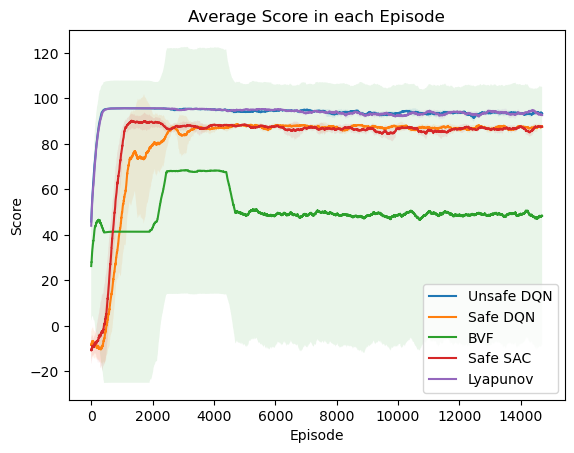

In [23]:
import os
import torch
import numpy as np
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import matplotlib.pyplot as plt
window = 300
avg_scores = []
avg_safescores = []
avg_bvfscores = []
avg_sacnewscores = []
avg_lypscores = []
for i in range(5):
    scores = torch.load("results/grid/normal/r"+str(i))
    safescores = torch.load("results/grid/safedqn/r"+str(i))
    bvfscores = torch.load("results/grid/bvf/r"+str(i))
    sacnewscores = torch.load("results/grid/sacnew/r"+str(i))
    lypscores = torch.load("results/grid/lyp/r"+str(i))
    
    scoresdisplay = [np.mean(scores[i-window:i]) for i in range(window,len(scores))]
    safescoresdisplay = [np.mean(safescores[i-window:i]) for i in range(window,len(safescores))]
    bvfscoresdisplay = [np.mean(bvfscores[i-window:i]) for i in range(window,len(bvfscores))]
    sacnewscoresdisplay = [np.mean(sacnewscores[i-window:i]) for i in range(window,len(sacnewscores))]
    lypscoresdisplay = [np.mean(lypscores[i-window:i]) for i in range(window,len(lypscores))]
    
    avg_scores.append(scoresdisplay)
    avg_safescores.append(safescoresdisplay)
    avg_bvfscores.append(bvfscoresdisplay)
    avg_sacnewscores.append(sacnewscoresdisplay)
    avg_lypscores.append(lypscoresdisplay)
    
avg_scores = np.array(avg_scores)
avg_safescores = np.array(avg_safescores)
avg_bvfscores = np.array(avg_bvfscores)
avg_sacnewscores = np.array(avg_sacnewscores)
avg_lypscores = np.array(avg_lypscores)

mean_scores = np.mean(avg_scores,axis=0)
mean_safescores = np.mean(avg_safescores,axis=0)
mean_bvfscores = np.mean(avg_bvfscores,axis=0)
mean_sacnewscores = np.mean(avg_sacnewscores,axis=0)
mean_lypscores = np.mean(avg_lypscores,axis=0)

std_scores = np.std(avg_scores,axis=0)
std_safescores = np.std(avg_safescores,axis=0)
std_bvfscores = np.std(avg_bvfscores,axis=0)
std_sacnewscores = np.std(avg_sacnewscores,axis=0)
std_lypscores = np.std(avg_lypscores,axis=0)

plt.plot(range(0,len(mean_scores)), mean_scores, label="Unsafe DQN")
plt.fill_between(range(0,len(mean_scores)), mean_scores + std_scores, mean_scores - std_scores, alpha = 0.1)
plt.plot(range(0,len(mean_safescores)), mean_safescores, label="Safe DQN")
plt.fill_between(range(0,len(mean_safescores)), mean_safescores + std_safescores, mean_safescores - std_safescores, alpha = 0.1)
plt.plot(range(0,len(mean_bvfscores)), mean_bvfscores, label="BVF")
plt.fill_between(range(0,len(mean_bvfscores)), mean_bvfscores + std_bvfscores, mean_bvfscores - std_bvfscores, alpha = 0.1)
plt.plot(range(0,len(mean_sacnewscores)), mean_sacnewscores, label="Safe SAC")
plt.fill_between(range(0,len(mean_sacnewscores)), mean_sacnewscores + std_sacnewscores, mean_sacnewscores - std_sacnewscores, alpha = 0.1)
plt.plot(range(0,len(mean_lypscores)), mean_lypscores, label="Lyapunov")
plt.fill_between(range(0,len(mean_lypscores)), mean_lypscores + std_lypscores, mean_lypscores - std_lypscores, alpha = 0.1)

plt.legend()
plt.xlabel('Episode')
plt.ylabel('Score')
plt.title('Average Score in each Episode')
plt.savefig('Figures/Grid_Scores',dpi=1080)
plt.show()

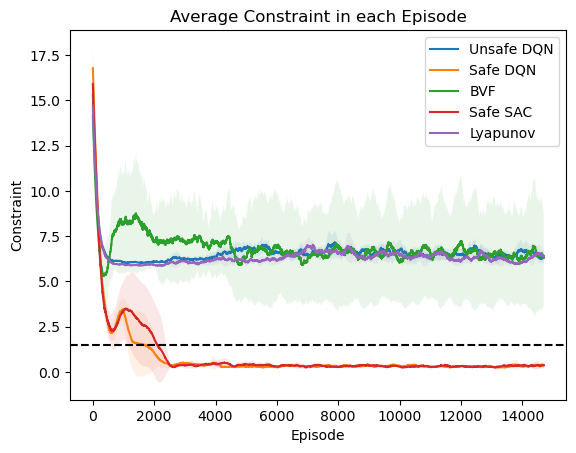

In [24]:
import os
import torch
import numpy as np
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import matplotlib.pyplot as plt
window = 300
avg_constraints = []
avg_safeconstraints = []
avg_bvfconstraints = []
avg_sacnewconstraints = []
avg_lypconstraints = []
for i in range(5):
    constraints = torch.load("results/grid/normal/c"+str(i))
    safeconstraints = torch.load("results/grid/safedqn/c"+str(i))
    bvfconstraints = torch.load("results/grid/bvf/c"+str(i))
    sacnewconstraints = torch.load("results/grid/sacnew/c"+str(i))
    lypconstraints = torch.load("results/grid/lyp/c"+str(i))

    constraintsdisplay = [np.mean(constraints[i-window:i]) for i in range(window,len(constraints))]
    safeconstraintsdisplay = [np.mean(safeconstraints[i-window:i]) for i in range(window,len(safeconstraints))]
    bvfconstraintsdisplay = [np.mean(bvfconstraints[i-window:i]) for i in range(window,len(bvfconstraints))]
    sacnewconstraintsdisplay = [np.mean(sacnewconstraints[i-window:i]) for i in range(window,len(sacnewconstraints))]
    lypconstraintsdisplay = [np.mean(lypconstraints[i-window:i]) for i in range(window,len(lypconstraints))]
    
    avg_constraints.append(constraintsdisplay)
    avg_safeconstraints.append(safeconstraintsdisplay)
    avg_bvfconstraints.append(bvfconstraintsdisplay)
    avg_sacnewconstraints.append(sacnewconstraintsdisplay)
    avg_lypconstraints.append(lypconstraintsdisplay)
    
avg_constraints = np.array(avg_constraints)
avg_safeconstraints = np.array(avg_safeconstraints)
avg_bvfconstraints = np.array(avg_bvfconstraints)
avg_sacnewconstraints = np.array(avg_sacnewconstraints)
avg_lypconstraints = np.array(avg_lypconstraints)

mean_constraints = np.mean(avg_constraints,axis=0)
mean_safeconstraints = np.mean(avg_safeconstraints,axis=0)
mean_bvfconstraints = np.mean(avg_bvfconstraints,axis=0)
mean_sacnewconstraints = np.mean(avg_sacnewconstraints,axis=0)
mean_lypconstraints = np.mean(avg_lypconstraints,axis=0)

std_constraints = np.std(avg_constraints,axis=0)
std_safeconstraints = np.std(avg_safeconstraints,axis=0)
std_bvfconstraints = np.std(avg_bvfconstraints,axis=0)
std_sacnewconstraints = np.std(avg_sacnewconstraints,axis=0)
std_lypconstraints = np.std(avg_lypconstraints,axis=0)

plt.plot(range(0,len(mean_constraints)), mean_constraints, label="Unsafe DQN")
plt.fill_between(range(0,len(mean_constraints)), mean_constraints + std_constraints, mean_constraints - std_constraints, alpha = 0.1)
plt.plot(range(0,len(mean_safeconstraints)), mean_safeconstraints, label="Safe DQN")
plt.fill_between(range(0,len(mean_safeconstraints)), mean_safeconstraints + std_safeconstraints, mean_safeconstraints - std_safeconstraints, alpha = 0.1)
plt.plot(range(0,len(mean_bvfconstraints)), mean_bvfconstraints, label="BVF")
plt.fill_between(range(0,len(mean_bvfconstraints)), mean_bvfconstraints + std_bvfconstraints, mean_bvfconstraints - std_bvfconstraints, alpha = 0.1)
plt.plot(range(0,len(mean_sacnewconstraints)), mean_sacnewconstraints, label="Safe SAC")
plt.fill_between(range(0,len(mean_sacnewconstraints)), mean_sacnewconstraints + std_sacnewconstraints, mean_sacnewconstraints - std_sacnewconstraints, alpha = 0.1)
plt.plot(range(0,len(mean_lypconstraints)), mean_lypconstraints, label="Lyapunov")
plt.fill_between(range(0,len(mean_lypconstraints)), mean_lypconstraints + std_lypconstraints, mean_lypconstraints - std_lypconstraints, alpha = 0.1)
plt.axhline(y=1.8, color='black', linestyle='--')
plt.legend()
plt.xlabel('Episode')
plt.ylabel('Constraint')
plt.title('Average Constraint in each Episode')
plt.savefig('Figures/Grid_Constraint',dpi=1080)
plt.show()